<a href="https://colab.research.google.com/github/kpjaskie/SenSIP-IRES2020/blob/master/Machine_Learning_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Algorithms

In this notebook, we will be performing different classification algorithms for comparison on simulated and real-world datasets.

In [1]:
# First, we need to import the relavent libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Let's make some simulated data to work with

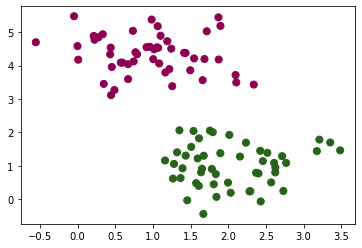

In [2]:
from sklearn.datasets import make_blobs

#Let's make some training data
X_sim_train, y_sim_train = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=0.60)
plt.scatter(X_sim_train[:, 0], X_sim_train[:, 1], c=y_sim_train, s=50, cmap='PiYG');

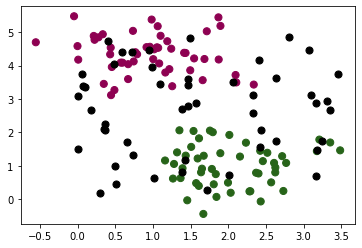

In [3]:
# generate random floating point values
from numpy.random import seed
from numpy.random import rand
# seed random number generator
seed(1)
# generate random numbers
X_sim_test = np.random.random((50,2))
X_sim_test[:,0] = 3.5 * X_sim_test[:,0]
X_sim_test[:,1] = 5 * X_sim_test[:,1]

plt.scatter(X_sim_train[:, 0], X_sim_train[:, 1], c=y_sim_train, s=50, cmap='PiYG');
plt.scatter(X_sim_test[:, 0], X_sim_test[:, 1], c='k', s=50);

# Logistic Regression


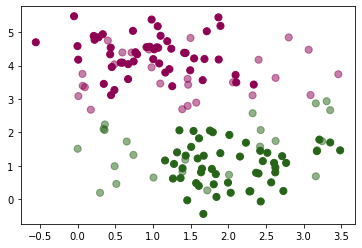

In [4]:
from sklearn.linear_model import LogisticRegression
from scipy import stats

#First, let's look at the simulated data
LR_model = LogisticRegression(random_state=0)

sim_model = LR_model.fit(X_sim_train, y_sim_train)
y_hat = sim_model.predict(X_sim_test)
prob_estimates = np.sort(sim_model.predict_proba(X_sim_test))


plt.figure(0)
plt.scatter(X_sim_train[:, 0], X_sim_train[:, 1], c=y_sim_train, s=50, cmap='PiYG');
plt.scatter(X_sim_test[:, 0], X_sim_test[:, 1], c=y_hat, s=50, cmap='PiYG', alpha=0.5);


In [ ]:
from sklearn.metrics import plot_confusion_matrix

CM = plot_confusion_matrix(sim_model, X, X_sim_test

#Support Vector Machines

A Support Vector Machine 

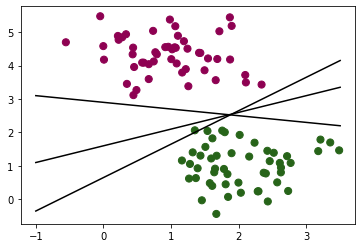

In [ ]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='PiYG')
#plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

#Neural Network Classifiers